<a href="https://colab.research.google.com/github/Malthr/sembago-ml/blob/main/Ranking_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.5 MB/s eta 0:00:00


In [ ]:
import os
import pprint
import pandas as pd

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/Machine Learning CH2-PS393/Dataset_Sembago

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Machine Learning CH2-PS393/Dataset_Sembago


In [ ]:
# Convert CSV Dataset into TensorFlow Dataset
def load_dataset(file_path, features, labels=None):
  df = pd.read_csv(file_path)

  features = df[features]

  if labels:
    labels = df[labels]
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  else:
    dataset = tf.data.Dataset.from_tensor_slices(dict(features))

  return dataset

In [ ]:
ratings = load_dataset('dummy_ratings.csv', ['id_user', 'id_produk', 'rating'])

In [ ]:
# Check Dataset Length
print(len(ratings))

3000


In [ ]:
ratings = ratings.map(lambda x: {
    "id_produk": x["id_produk"],
    "id_user": x["id_user"],
    "rating": x["rating"]
})

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(1_000, seed=42, reshuffle_each_iteration=False)

train_percentage = 80

train_size = int(train_percentage / 100 * len(ratings))
test_size = int((100 - train_percentage) / 100 * len(ratings))

train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

In [ ]:
# Check Splitted Data Length
print(len(train))
print(len(test))

2400
600


In [ ]:
id_produks = ratings.batch(1_000).map(lambda x: x["id_produk"])
id_users = ratings.batch(1_000).map(lambda x: x["id_user"])

unique_id_produks = np.unique(np.concatenate(list(id_produks)))
unique_id_users = np.unique(np.concatenate(list(id_users)))

In [ ]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 128

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_id_users, mask_token=None),
      tf.keras.layers.Embedding(len(unique_id_users) + 1, embedding_dimension)
    ])

    # Compute embeddings for produks.
    self.produk_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_id_produks, mask_token=None),
      tf.keras.layers.Embedding(len(unique_id_produks) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(32, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    id_user, id_produk = inputs

    user_embedding = self.user_embeddings(id_user)
    produk_embedding = self.produk_embeddings(id_produk)

    return self.ratings(tf.concat([user_embedding, produk_embedding], axis=1))

In [ ]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
class ProdRankingRecModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["id_user"], features["id_produk"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [ ]:
model = ProdRankingRecModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001))

In [ ]:
cached_train = train.shuffle(100).batch(16).cache()
cached_test = test.batch(16).cache()

In [ ]:
# Check Cached Data Length
print(len(cached_train))
print(len(cached_test))

150
38


In [ ]:
history = model.fit(cached_train, epochs=100)

Epoch 1/100
150/150 [==============================] - 2s 3ms/step - root_mean_squared_error: 3.1937 - loss: 10.2025 - regularization_loss: 0.0000e+00 - total_loss: 10.2025
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - root_mean_squared_error: 3.0715 - loss: 9.4367 - regularization_loss: 0.0000e+00 - total_loss: 9.4367
Epoch 3/100
150/150 [==============================] - 1s 3ms/step - root_mean_squared_error: 2.9477 - loss: 8.6918 - regularization_loss: 0.0000e+00 - total_loss: 8.6918
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - root_mean_squared_error: 2.8113 - loss: 7.9055 - regularization_loss: 0.0000e+00 - total_loss: 7.9055
Epoch 5/100
150/150 [==============================] - 1s 3ms/step - root_mean_squared_error: 2.6590 - loss: 7.0722 - regularization_loss: 0.0000e+00 - total_loss: 7.0722
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - root_mean_squared_error: 2.4897 - loss: 6.2002 - regularization_loss: 0.00

In [ ]:
model.evaluate(cached_test, return_dict=True)

38/38 [==============================] - 0s 2ms/step - root_mean_squared_error: 1.6614 - loss: 2.6877 - regularization_loss: 0.0000e+00 - total_loss: 2.6877


{'root_mean_squared_error': 1.6613962650299072,
 'loss': 0.8744914531707764,
 'regularization_loss': 0,
 'total_loss': 0.8744914531707764}

<Figure size 640x480 with 0 Axes>

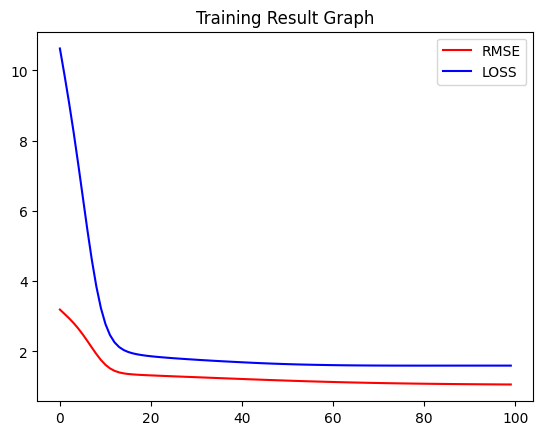

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

rmse = history.history['root_mean_squared_error']
loss = history.history['loss']

epochs = range(len(rmse))

plt.plot(epochs, rmse, 'r', label='RMSE')
plt.plot(epochs, loss, 'b', label='LOSS')
plt.title('Training Result Graph')
plt.legend(loc=0)
plt.figure()

In [ ]:
tf.saved_model.save(model, "ranking_model")